In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

import DataExtractor
import datetime

import warnings
warnings.filterwarnings('ignore')

2023-12-12 15:09:19.539552: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
NP_RANDOM_SEED = 1234567890

In [5]:
cryptoList : list[str] = ["ETH-USD", "BTC-USD", "DASH-USD", "XRP-USD"]

In [6]:
cryptoDataFrameDict : dict[str, pd.DataFrame] = {}
for crypto in cryptoList :
    inputFileName : str = crypto + "_Data.csv"
    inputFilePath = os.path.join("./", "data", inputFileName)
    dataFrame : pd.DataFrame = pd.read_csv(filepath_or_buffer = inputFilePath)
    cryptoDataFrameDict[crypto] = dataFrame 

In [7]:
def logConvertion(dataFrame : pd.DataFrame, columnName : str) :
    dataFrame["LogClosePrice"] = np.log10(dataFrame[columnName])

In [9]:
for crypto in cryptoList :
    cryptoDf : pd.DataFrame = cryptoDataFrameDict[crypto]
    logConvertion(cryptoDf, "Close")

cryptoDataFrameDict["ETH-USD"]["LogClosePrice"]

0       2.887978
1       2.946670
2       2.983500
3       2.991634
4       2.999009
          ...   
2065    3.218130
2066    3.237977
2067    3.231753
2068    3.216335
2069    3.211785
Name: LogClosePrice, Length: 2070, dtype: float64

In [ ]:
colors = ["blue", "green", "red", "fuchsia"]

In [10]:
differencingDict : dict[str, pd.DataFrame] = {}
for crypto in cryptoDataFrameDict :
    logPriceSeries : pd.Series = cryptoDataFrameDict[crypto]["LogClosePrice"]
    differencing : pd.Series = logPriceSeries.diff()
    differencing.dropna(inplace = True)
    differencing.reset_index(inplace = True, drop = True)
    differencingDict[crypto] = pd.DataFrame({"Diff" : differencing.values, "QuadDiff" : (differencing.pow(2)).values})

In [11]:
# TOY EXAMPLE of windowing
raw_dataset = tf.data.Dataset.range(6)
for element in raw_dataset:
    print(element)

dataset = raw_dataset.window(4, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window_dataset: window_dataset.batch(4))
for window_tensor in dataset:
    print(f"{window_tensor}")

tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(5, shape=(), dtype=int64)
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
[0 1 2 3]
[1 2 3 4]
[2 3 4 5]


2023-12-12 15:12:12.292362: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-12 15:12:12.298344: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [65]:
seq_length = 30 # 8 weeks
tf.random.set_seed(42)  # extra code – ensures reproducibility

trainPoints = differencingDict["ETH-USD"].index < int(differencingDict["ETH-USD"].shape[0] * 80 / 100)
testPoints = differencingDict["ETH-USD"].index >= int(differencingDict["ETH-USD"].shape[0] * 80 / 100)

trainSet = differencingDict["ETH-USD"][trainPoints]["Diff"]
testSet = differencingDict["ETH-USD"][testPoints]["Diff"]

validPoints = trainSet.index >= int(trainSet.shape[0] * 80 / 100)
validSet = trainSet[validPoints]

trainSet = trainSet[0 : int(trainSet.shape[0] * 80 / 100)]

print(trainSet)
print(validSet)
print(testSet)

train_ds = tf.keras.utils.timeseries_dataset_from_array(
    trainSet.to_numpy(),
    targets = trainSet[seq_length :],
    sequence_length = seq_length,
    batch_size = 32,
    shuffle = True,
    seed = 42
)
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    validSet.to_numpy(),
    targets = validSet[seq_length :],
    sequence_length = seq_length,
    batch_size = 32
)

0       0.058693
1       0.036830
2       0.008134
3       0.007374
4       0.018726
          ...   
1319    0.038066
1320   -0.007485
1321    0.005952
1322   -0.020687
1323   -0.019942
Name: Diff, Length: 1324, dtype: float64
1324    0.000755
1325    0.022776
1326    0.013995
1327   -0.008115
1328    0.002153
          ...   
1650   -0.017691
1651   -0.027292
1652   -0.024023
1653    0.030447
1654    0.029379
Name: Diff, Length: 331, dtype: float64
1655    0.014905
1656    0.040169
1657   -0.004515
1658    0.071642
1659   -0.009946
          ...   
2064   -0.001327
2065    0.019847
2066   -0.006224
2067   -0.015418
2068   -0.004549
Name: Diff, Length: 414, dtype: float64


In [66]:
# a utility function we'll reuse several time
def fit_and_evaluate(model, train_set, 
                     valid_set, epochs=500, opt="adam", eval=True):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=50, restore_best_weights=True)
    
    
    
    model.compile(loss=tf.keras.losses.Huber(), 
                  optimizer=opt, metrics=["mae", "mape"])
    
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs,
                        callbacks=[early_stopping_cb])
    if eval:
        valid_loss, valid_mae, valid_mape = model.evaluate(valid_set)
        return valid_mape

In [67]:
tf.random.set_seed(42) 
univar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 1]), # None: sequences of any length
    tf.keras.layers.Dense(1)  # no activation function by default
])

In [68]:
fit_and_evaluate(univar_model, train_ds, valid_ds, opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9))

Epoch 1/500
41/41 [==============================] - 2s 24ms/step - loss: 0.0012 - mae: 0.0365 - mape: 1735.2905 - val_loss: 6.1410e-04 - val_mae: 0.0270 - val_mape: 1899.6135
Epoch 2/500
41/41 [==============================] - 1s 22ms/step - loss: 7.4914e-04 - mae: 0.0291 - mape: 1232.4316 - val_loss: 4.8548e-04 - val_mae: 0.0245 - val_mape: 1300.8390
Epoch 3/500
41/41 [==============================] - 1s 19ms/step - loss: 6.2014e-04 - mae: 0.0262 - mape: 1044.6608 - val_loss: 4.0544e-04 - val_mae: 0.0223 - val_mape: 1629.0609
Epoch 4/500
41/41 [==============================] - 1s 22ms/step - loss: 5.4666e-04 - mae: 0.0246 - mape: 1004.3256 - val_loss: 3.6470e-04 - val_mae: 0.0213 - val_mape: 1421.5096
Epoch 5/500
41/41 [==============================] - 1s 23ms/step - loss: 5.0318e-04 - mae: 0.0236 - mape: 958.7610 - val_loss: 3.3851e-04 - val_mae: 0.0205 - val_mape: 1535.8759
Epoch 6/500
41/41 [==============================] - 1s 22ms/step - loss: 4.6930e-04 - mae: 0.0226 - mape

560.8336181640625

13/13 [==============================] - 0s 3ms/step


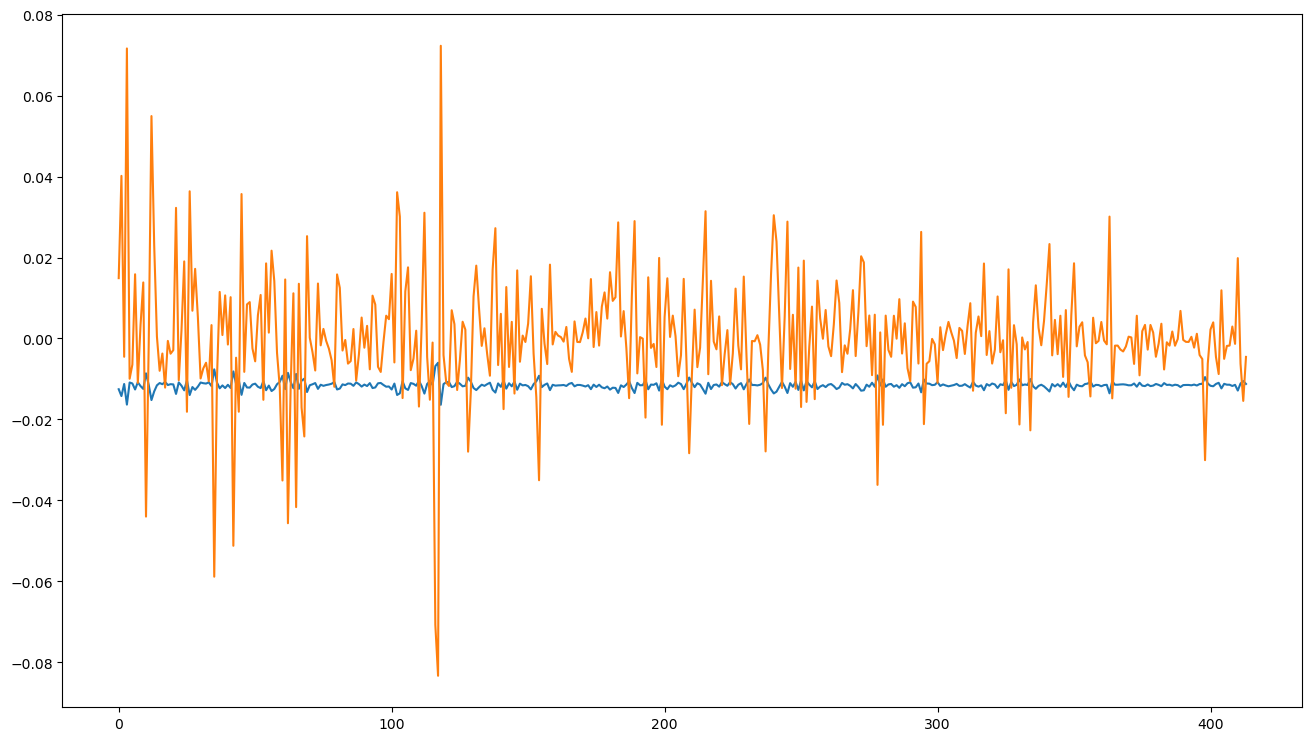

In [69]:
predicted = univar_model.predict(testSet)
plt.figure(figsize = (16, 9))
plt.plot(np.arange(0, testSet.shape[0], 1), predicted)
plt.plot(np.arange(0, testSet.shape[0], 1), testSet)